In [2]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import pandas as pd
import json

from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import textwrap

/home/andreapdr/miniconda3/envs/latestorch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/andreapdr/miniconda3/envs/latestorch/lib/python3.9/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [3]:
ft_path = "../checkpoints-classifier/roberta/checkpoint-100"

In [4]:
model = AutoModelForSequenceClassification.from_pretrained(ft_path)
tokenizer = AutoTokenizer.from_pretrained(ft_path)

In [5]:
data = pd.read_json("../data/generation_output_llama-3.1-70b-instruct-hf_xsum_informed.jsonl", lines=True)
selected = json.load(open("../data/splits/llama-3.1-70b-instruct-hf_xsum_informed.split.10000.json"))

tr_data = data[data["id"].isin(selected["tr"])]
va_data = data[data["id"].isin(selected["val"])]
te_data = data[data["id"].isin(selected["te"])]

In [6]:
idx = 0

real = te_data.iloc[idx].real_article
synth = te_data.iloc[idx].generated_text

## Neural Classifier

In [7]:
print(textwrap.fill(real, width=100))

logits = model(**tokenizer(real, return_tensors="pt")).logits.detach()
print(f'\n{logits} - argmax: {logits.argmax()}')

The full cost of damage in Newton Stewart, one of the areas worst affected, is still being assessed.
Repair work is ongoing in Hawick and many roads in Peeblesshire remain badly affected by standing
water. Trains on the west coast mainline face disruption due to damage at the Lamington Viaduct.
Many businesses and householders were affected by flooding in Newton Stewart after the River Cree
overflowed into the town. First Minister Nicola Sturgeon visited the area to inspect the damage. The
waters breached a retaining wall, flooding many commercial properties on Victoria Street - the main
shopping thoroughfare. Jeanette Tate, who owns the Cinnamon Cafe which was badly affected, said she
could not fault the multi-agency response once the flood hit. However, she said more preventative
work could have been carried out to ensure the retaining wall did not fail. "It is difficult but I
do think there is so much publicity for Dumfries and the Nith - and I totally appreciate that - but
it is al

In [8]:
print(textwrap.fill(synth, width=100))

logits = model(**tokenizer(synth, return_tensors="pt")).logits.detach()
print(f'\n{logits} - argmax: {logits.argmax()}')


Residents in the Scottish Borders and Dumfries and Galloway are facing a long and arduous clean-up
operation after severe flooding hit the regions, leaving a trail of destruction in its wake. The
flooding, which occurred after heavy rainfall caused rivers to burst their banks, has resulted in
widespread damage to homes, businesses, and infrastructure. In the town of Hawick, the River Teviot
overflowed, inundating homes and shops, with many residents forced to evacuate their properties. The
town's main street was left underwater, with debris and silt covering the roads and pavements.
Emergency services, including the fire brigade and mountain rescue teams, were quickly deployed to
assist with the evacuation efforts and provide support to those affected. In Dumfries and Galloway,
the River Nith also burst its banks, causing significant flooding in the town of Dumfries. The
town's Whitesands area was particularly badly affected, with many homes and businesses flooded. The
local council ha

In [9]:
for line in real.split(". "):
    print(line)
    print(model(**tokenizer(line, return_tensors="pt")).logits)
    print("\n")

The full cost of damage in Newton Stewart, one of the areas worst affected, is still being assessed
tensor([[-0.0427, -0.1696]], grad_fn=<AddmmBackward0>)


Repair work is ongoing in Hawick and many roads in Peeblesshire remain badly affected by standing water
tensor([[-0.5210,  0.3242]], grad_fn=<AddmmBackward0>)


Trains on the west coast mainline face disruption due to damage at the Lamington Viaduct
tensor([[-0.5453,  0.3580]], grad_fn=<AddmmBackward0>)


Many businesses and householders were affected by flooding in Newton Stewart after the River Cree overflowed into the town
tensor([[-0.4944,  0.3003]], grad_fn=<AddmmBackward0>)


First Minister Nicola Sturgeon visited the area to inspect the damage
tensor([[-0.2218,  0.0079]], grad_fn=<AddmmBackward0>)


The waters breached a retaining wall, flooding many commercial properties on Victoria Street - the main shopping thoroughfare
tensor([[-0.4873,  0.2954]], grad_fn=<AddmmBackward0>)


Jeanette Tate, who owns the Cinnamon Cafe whic

In [10]:
for line in synth.split(". "):
    print(line)
    print(model(**tokenizer(line, return_tensors="pt")).logits)
    print("\n")

Residents in the Scottish Borders and Dumfries and Galloway are facing a long and arduous clean-up operation after severe flooding hit the regions, leaving a trail of destruction in its wake
tensor([[-2.0618,  1.8663]], grad_fn=<AddmmBackward0>)


The flooding, which occurred after heavy rainfall caused rivers to burst their banks, has resulted in widespread damage to homes, businesses, and infrastructure
tensor([[-1.3472,  1.1487]], grad_fn=<AddmmBackward0>)


In the town of Hawick, the River Teviot overflowed, inundating homes and shops, with many residents forced to evacuate their properties
tensor([[-0.5708,  0.4083]], grad_fn=<AddmmBackward0>)


The town's main street was left underwater, with debris and silt covering the roads and pavements
tensor([[-0.4665,  0.2742]], grad_fn=<AddmmBackward0>)


Emergency services, including the fire brigade and mountain rescue teams, were quickly deployed to assist with the evacuation efforts and provide support to those affected
tensor([[-0.30

## TFIDF

In [11]:
class TfidfTokenizer:
    def __init__(self, tokenizer, max_length=512):
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __call__(self, text):
        return self.tokenizer.tokenize(text, add_special_tokens=False)

In [12]:
tr_real = tr_data.real_article.to_list()
tr_synth = tr_data.generated_text.to_list()

stop_words = "english"
tfidf_tokenizer = None # TfidfTokenizer(tokenizer=tokenizer, max_length=512) # None

tr_real_vectorizer = TfidfVectorizer(analyzer="word", tokenizer=tfidf_tokenizer, stop_words=stop_words, max_features=250)
tr_real_tfidf_vector = tr_real_vectorizer.fit_transform(tr_real)

tr_synth_vectorizer = TfidfVectorizer(analyzer="word", tokenizer=tfidf_tokenizer, stop_words=stop_words, max_features=250)
tr_synth_tfidf_vector = tr_synth_vectorizer.fit_transform(tr_synth)

In [13]:
tfidf_df_real = pd.DataFrame(tr_real_tfidf_vector.toarray(), index=tr_data.id.to_list(), columns=tr_real_vectorizer.get_feature_names_out())
tfidf_df_synth = pd.DataFrame(tr_synth_tfidf_vector.toarray(), index=tr_data.id.to_list(), columns=tr_synth_vectorizer.get_feature_names_out())

In [14]:
tfidf_df_real.loc['00_document_frequency'] = (tfidf_df_real > 0).sum()
tfidf_df_real.loc["00_average_tfidf"] = tfidf_df_real.mean(axis=0)


tfidf_df_synth.loc['00_document_frequency'] = (tfidf_df_synth > 0).sum()
tfidf_df_synth.loc["00_average_tfidf"] = tfidf_df_synth.mean(axis=0)

In [15]:
top_k = 25

top_k_real = tfidf_df_real.loc["00_average_tfidf"].sort_values(ascending=False)[:top_k]
top_k_synth = tfidf_df_synth.loc["00_average_tfidf"].sort_values(ascending=False)[:top_k]

In [16]:
top_k_real

said          0.971639
year          0.567910
people        0.481777
time          0.475008
mr            0.431153
told          0.412129
years         0.410307
new           0.399919
just          0.362731
bbc           0.360667
added         0.339259
world         0.292048
like          0.288212
make          0.282619
government    0.279793
way           0.276057
old           0.271353
work          0.263804
day           0.255304
did           0.254231
000           0.253727
home          0.248353
going         0.246204
uk            0.246163
place         0.233659
Name: 00_average_tfidf, dtype: float64

In [17]:
top_k_synth

significant    0.463124
including      0.429489
year           0.382888
said           0.348275
new            0.332287
years          0.324220
government     0.323748
uk             0.316995
seen           0.307306
recent         0.297904
expected       0.290370
concerns       0.262489
team           0.254608
country        0.254329
major          0.251869
set            0.246700
time           0.231978
despite        0.228281
support        0.228265
long           0.226491
according      0.225018
old            0.222144
likely         0.219072
people         0.215821
high           0.210465
Name: 00_average_tfidf, dtype: float64

In [18]:
set(top_k_synth.index.to_list()) - set(top_k_real.index.to_list())

{'according',
 'concerns',
 'country',
 'despite',
 'expected',
 'high',
 'including',
 'likely',
 'long',
 'major',
 'recent',
 'seen',
 'set',
 'significant',
 'support',
 'team'}

## TFIDF classifier

In [19]:
def create_dataset(df_data):
    df_real         = df_data[["real_article", "id", "source"]].rename(columns={"real_article": "text"})
    df_generated    = df_data[["generated_text", "id", "source"]].rename(columns={"generated_text": "text"})
    
    df_real["label"] = 0
    df_generated["label"] = 1

    df_data = pd.concat([df_real, df_generated], ignore_index=True)

    return df_data

In [20]:
tr_dataset = create_dataset(tr_data)
te_dataset = create_dataset(te_data)

In [21]:
tr_vectorizer = TfidfVectorizer(analyzer="word", tokenizer=None, stop_words="english", max_features=250)
tr_X = tr_vectorizer.fit_transform(tr_dataset.text)
tr_Y = tr_dataset.label.to_numpy()

te_X = tr_vectorizer.transform(te_dataset.text)
te_Y = te_dataset.label.to_numpy()

In [55]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score
import numpy as np


model = SVC(kernel='linear')
model.fit(tr_X, tr_Y)
y_pred = model.predict(te_X)

print(classification_report(te_Y, y_pred))
print(f"{f1_score(y_true=te_Y, y_pred=y_pred)=:.2f}")
print(f"{accuracy_score(y_true=te_Y, y_pred=y_pred)=:.2f}")
print(f"{precision_score(y_true=te_Y, y_pred=y_pred)=:.2f}")
print(f"{recall_score(y_true=te_Y, y_pred=y_pred)=:.2f}")

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      2250
           1       0.95      0.96      0.95      2250

    accuracy                           0.95      4500
   macro avg       0.95      0.95      0.95      4500
weighted avg       0.95      0.95      0.95      4500

f1_score(y_true=te_Y, y_pred=y_pred)=0.95
accuracy_score(y_true=te_Y, y_pred=y_pred)=0.95
precision_score(y_true=te_Y, y_pred=y_pred)=0.95
recall_score(y_true=te_Y, y_pred=y_pred)=0.96


In [56]:
coeffs = model.coef_.toarray()

In [57]:
feature_names = tr_vectorizer.get_feature_names_out()

In [89]:
top_n = 50
for class_index, class_coefficients in enumerate(coeffs):
    top_features_indices = np.argsort(class_coefficients)[-top_n:]
    negatige_features_indices = np.argsort(class_coefficients)[:top_n]
    prominent_features = [(feature_names[i], class_coefficients[i]) for i in top_features_indices]
    negative_features = [(feature_names[i], class_coefficients[i]) for i in negatige_features_indices]

    print(f"\nTop features for syntethic detection:")
    for feature, coef in prominent_features[::-1]:
        print(f"{feature}: {coef:.4f}")

    
    print(f"\nNegative features for syntethic detection:")
    for feature, coef in negative_features:
        print(f"{feature}: {coef:.4f}")


Top features for syntethic detection:
significant: 6.4697
expressed: 4.8595
despite: 4.0373
including: 4.0011
saying: 3.1610
looking: 2.5683
expected: 2.5467
recent: 2.3636
victory: 2.2357
according: 2.2103
major: 2.1976
provide: 2.0998
seen: 2.0776
concerns: 2.0494
incident: 1.9962
remain: 1.8713
likely: 1.8160
old: 1.7847
key: 1.7565
impact: 1.6905
community: 1.6141
come: 1.6054
coming: 1.6005
need: 1.5817
investigation: 1.5446
continue: 1.3097
increase: 1.3058
hard: 1.2480
decision: 1.2265
performance: 1.2044
team: 1.1034
social: 1.0990
groups: 1.0866
fans: 1.0808
strong: 1.0616
working: 1.0412
potential: 1.0318
role: 1.0255
lead: 1.0016
support: 0.9829
ve: 0.9026
just: 0.8822
family: 0.8535
face: 0.7916
manager: 0.7778
local: 0.7722
making: 0.7399
attack: 0.7259
british: 0.6829
win: 0.6821

Negative features for syntethic detection:
said: -8.3032
says: -5.1858
say: -3.8356
told: -3.8044
added: -3.7541
like: -3.2808
month: -3.1428
mr: -3.1419
really: -2.9514
did: -2.9445
year: -2.8

In [116]:
tr_vectorizer.vocabulary_

{'final': 69,
 'half': 90,
 'second': 198,
 'clear': 31,
 'start': 211,
 'ahead': 9,
 'team': 218,
 'world': 246,
 'seen': 200,
 'said': 190,
 'given': 81,
 'did': 52,
 'good': 84,
 'concerns': 38,
 'corner': 40,
 'best': 17,
 'attempt': 13,
 'just': 112,
 'expected': 63,
 'year': 247,
 'strong': 214,
 'think': 219,
 'hard': 91,
 'time': 220,
 'far': 68,
 'season': 197,
 'weeks': 237,
 'old': 156,
 'known': 116,
 'run': 188,
 'new': 150,
 'despite': 51,
 '2015': 4,
 'president': 174,
 'place': 163,
 'come': 34,
 'result': 184,
 'action': 7,
 'end': 58,
 'local': 128,
 'able': 5,
 'change': 28,
 'people': 161,
 'way': 235,
 'london': 129,
 'including': 103,
 'mr': 146,
 'told': 222,
 'leader': 121,
 'south': 208,
 'says': 193,
 'home': 98,
 'number': 154,
 'taken': 216,
 'later': 118,
 'group': 88,
 'police': 171,
 'got': 85,
 'game': 79,
 'following': 71,
 'took': 223,
 'match': 137,
 'centre': 27,
 'long': 130,
 'early': 54,
 'close': 32,
 '10': 1,
 'goal': 82,
 'make': 133,
 'man': 1

In [22]:
tfidf_tokenizer = tr_vectorizer.build_tokenizer()

count_vectorizer = CountVectorizer(vocabulary=tr_vectorizer.vocabulary_)

In [23]:
real_count_vectors = count_vectorizer.transform(tr_real)
synth_count_vectors = count_vectorizer.transform(tr_synth)
dist_real = real_count_vectors.sum(axis=0)
dist_synth = synth_count_vectors.sum(axis=0)

In [24]:
real_dist = {
    word: dist_real[0, idx] for word, idx in count_vectorizer.vocabulary_.items()
}

synth_dist = {
    word: dist_synth[0, idx] for word, idx in count_vectorizer.vocabulary_.items()
}


In [26]:
df_real = pd.DataFrame(list(real_dist.items()), columns=['Category', 'Count'])
# df_real['Distribution'] = 'Real Texts'
df_synth = pd.DataFrame(list(synth_dist.items()), columns=['Category', 'Count'])
# df_synth['Distribution'] = 'Synthetic Texts'

In [44]:
df_real_sorted = df_real.sort_values(by='Count', ascending=True)
df_synth_sorted = df_synth.set_index('Category').loc[df_real_sorted['Category']].reset_index()

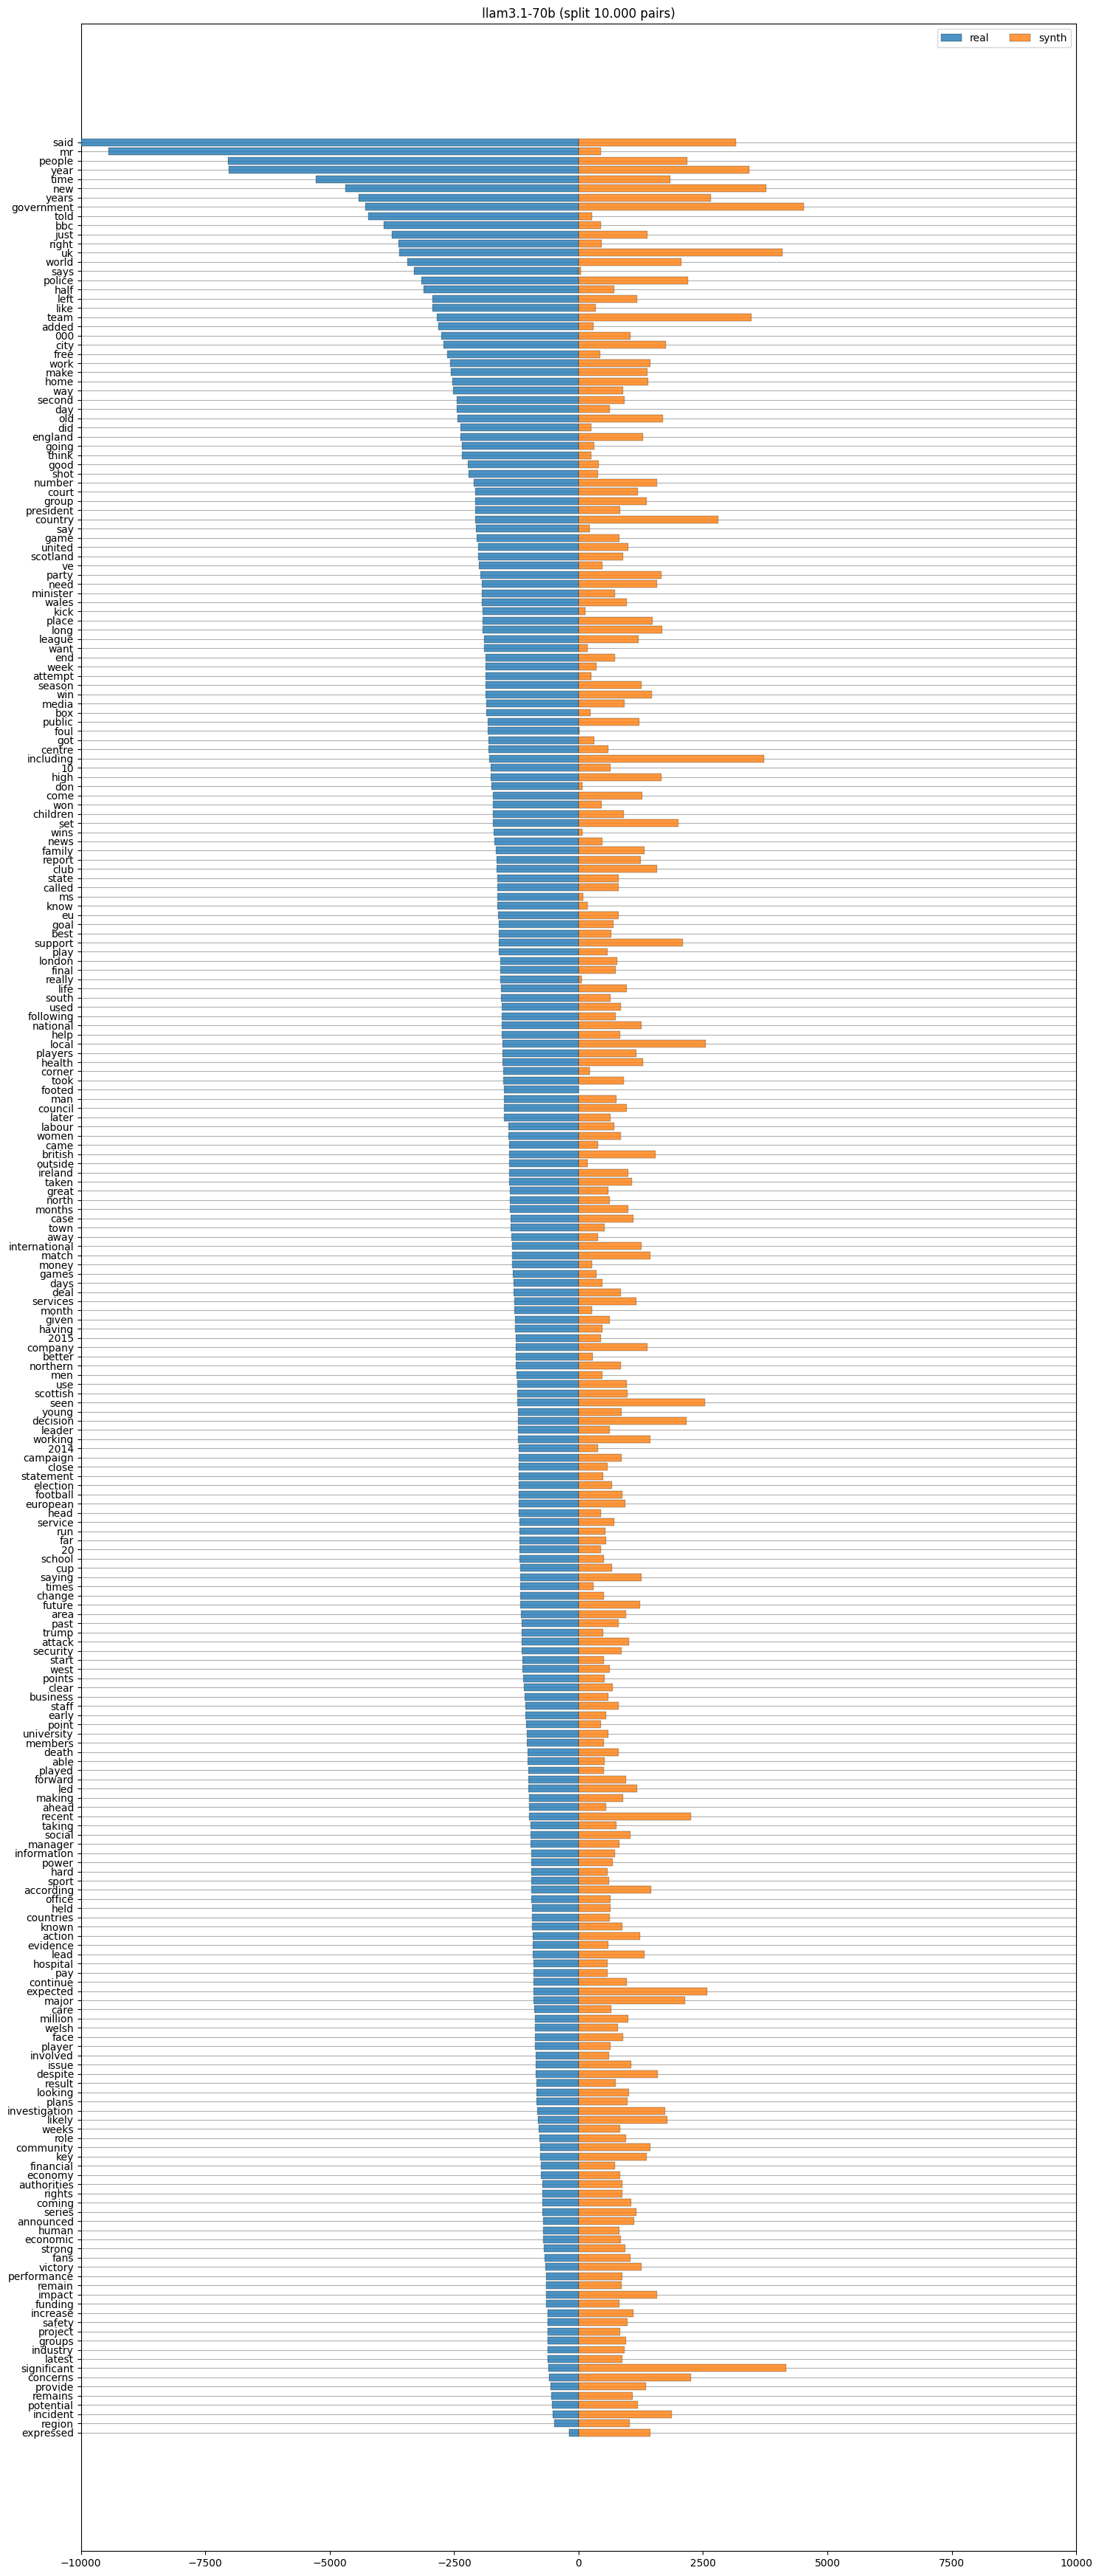

In [72]:
fig, ax = plt.subplots(figsize=(15, 35), layout="tight")

ax.barh(df_real_sorted['Category'], -df_real_sorted['Count'],
        alpha=0.8, edgecolor="black", label="real", linewidth=0.25, zorder=3)
ax.barh(df_synth_sorted['Category'], df_synth_sorted['Count'],
        alpha=0.8, edgecolor="black", label="synth", linewidth=0.25, zorder=3)

ax.set_xlim(-10000, 10000)
plt.legend(ncols=2)

ax.grid(axis="y", zorder=0)
plt.title("llam3.1-70b (split 10.000 pairs)")
plt.show()